# Global Temperature Data Forecasting
## Ethan Chee, David Feng, and Lori Sun

The eventual goal is to use this dataset and others and train a machine learning model to see if it can predict the test temperatures we feed it and also possibly future temperatures, in light of global temperatures trends caused by global warming and other environmental components.

A video of our final project video, which was too large to submit to gradescope, can be found here: https://youtu.be/E-xfIh1e748

## Initial Setup and Imports

In [1]:
!pip install pandas==1.1.5
# Import neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import datetime as dt
import requests
from lxml import html

     |████████████████████████████████| 9.5 MB 5.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [2]:
!nvidia-smi

Mon May  2 19:48:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [4]:
import mxnet as mx
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np

In [5]:
from mxnet import npx
from mxnet.gluon import nn
npx.set_np()

npx.num_gpus()

1

## Create and Clean Dataset on Global Land Temperatures

This dataset contains average land temperatures by city for every month spanning back all the way to the 1700s. Here we perform EDA and clean this data, removing much of the data from before the 1900s since we won't be able to join that data with the data from other datasets anyways, since they don't span as far back. 

In order to use the datasets in the project, just upload all the csv files uploaded to Gradescope to Colab under the Files tab using the Upload to session storage button. The only dataset that could not be uploaded due to its size is the main Global Land Temperatures By City csv because it was too large (it's the one right below this, and also takes a very long time to upload to Colab) but it is one of the recommended datasets and can be found at this link to Kaggle and directly downloaded from here.
https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

In [6]:
# Load the dataset and perform some basic EDA
temperatures_df = pd.read_csv('/content/GlobalLandTemperaturesByCity.csv')
temperatures_df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E


In [7]:
temperatures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [8]:
temperatures_df.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E
9,1744-08-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [9]:
temperatures_df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [10]:
# Drop all null values and remove data from before 1960 to reduce the size of the dataset for future cleaning and also because
# later when we merge with the other datasets, there isn't any data from before this point
temperatures_df = temperatures_df.dropna(axis=0, subset=["AverageTemperature", "City", "Country", "Latitude", "Longitude"])
temperatures_df = temperatures_df[temperatures_df["dt"] >= '1960-01-01'].reset_index(drop=True)
temperatures_df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1960-01-01,-0.657,0.319,Århus,Denmark,57.05N,10.33E
1,1960-02-01,-1.359,0.366,Århus,Denmark,57.05N,10.33E
2,1960-03-01,2.339,0.360,Århus,Denmark,57.05N,10.33E
3,1960-04-01,5.919,0.171,Århus,Denmark,57.05N,10.33E
4,1960-05-01,12.214,0.334,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
2260875,2013-04-01,7.710,0.182,Zwolle,Netherlands,52.24N,5.26E
2260876,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
2260877,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
2260878,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E


In [11]:
# Convert longitude and latitude values into numerical floats, with South and West being converted into negative values
def new_lat(old_lat):
  latitude = ""
  if (old_lat[-1] == "N"):
    latitude = old_lat[:-1]
  elif (old_lat[-1] == "S"):
    latitude = "-" + old_lat[:-1]
  latitude = float(latitude)
  return latitude
temperatures_df["Latitude"] = temperatures_df["Latitude"].apply(lambda x: new_lat(x)) 

def new_long(old_long):
  longitude = old_long
  if (old_long[-1] == "E"):
    longitude = old_long[:-1]
  elif (old_long[-1] == "W"):
    longitude = "-" + old_long[:-1]
  longitude = float(longitude)
  return longitude
temperatures_df["Longitude"] = temperatures_df["Longitude"].apply(lambda x: new_long(x))
temperatures_df


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1960-01-01,-0.657,0.319,Århus,Denmark,57.05,10.33
1,1960-02-01,-1.359,0.366,Århus,Denmark,57.05,10.33
2,1960-03-01,2.339,0.360,Århus,Denmark,57.05,10.33
3,1960-04-01,5.919,0.171,Århus,Denmark,57.05,10.33
4,1960-05-01,12.214,0.334,Århus,Denmark,57.05,10.33
...,...,...,...,...,...,...,...
2260875,2013-04-01,7.710,0.182,Zwolle,Netherlands,52.24,5.26
2260876,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24,5.26
2260877,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24,5.26
2260878,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24,5.26


In [12]:
temperatures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260880 entries, 0 to 2260879
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       float64
 6   Longitude                      float64
dtypes: float64(4), object(3)
memory usage: 120.7+ MB


In [13]:
# Converts datetime column into datetime type
temperatures_df['dt'] = temperatures_df['dt'].apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d'))
temperatures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260880 entries, 0 to 2260879
Data columns (total 7 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   dt                             datetime64[ns]
 1   AverageTemperature             float64       
 2   AverageTemperatureUncertainty  float64       
 3   City                           object        
 4   Country                        object        
 5   Latitude                       float64       
 6   Longitude                      float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 120.7+ MB


In [14]:
# Create separate year, day, and month columns
temperatures_df['Year'] = temperatures_df['dt'].apply(lambda x : x.year)
temperatures_df['Day'] = temperatures_df['dt'].apply(lambda x : x.day)
temperatures_df['Month'] = temperatures_df['dt'].apply(lambda x : x.month)
temperatures_df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Day,Month
0,1960-01-01,-0.657,0.319,Århus,Denmark,57.05,10.33,1960,1,1
1,1960-02-01,-1.359,0.366,Århus,Denmark,57.05,10.33,1960,1,2
2,1960-03-01,2.339,0.360,Århus,Denmark,57.05,10.33,1960,1,3
3,1960-04-01,5.919,0.171,Århus,Denmark,57.05,10.33,1960,1,4
4,1960-05-01,12.214,0.334,Århus,Denmark,57.05,10.33,1960,1,5
...,...,...,...,...,...,...,...,...,...,...
2260875,2013-04-01,7.710,0.182,Zwolle,Netherlands,52.24,5.26,2013,1,4
2260876,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24,5.26,2013,1,5
2260877,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24,5.26,2013,1,6
2260878,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24,5.26,2013,1,7


In [15]:
# Find the average temperature worldwide for each datetime so that we can observe overall temperature trends over time
temperatures_by_date_df = temperatures_df.groupby(["dt"]).mean().reset_index()
temperatures_by_date_df

,dt,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Year,Day,Month
0,1960-01-01,11.187527,0.416467,22.850567,32.272490,1960,1,1
1,1960-02-01,12.970319,0.449173,22.850567,32.272490,1960,1,2
2,1960-03-01,14.830228,0.353812,22.850567,32.272490,1960,1,3
3,1960-04-01,18.017891,0.364765,22.850567,32.272490,1960,1,4
4,1960-05-01,20.733568,0.449751,22.850567,32.272490,1960,1,5
...,...,...,...,...,...,...,...,...
640,2013-05-01,21.748558,0.486444,22.850567,32.272490,2013,1,5
641,2013-06-01,23.263550,0.510929,22.850567,32.272490,2013,1,6
642,2013-07-01,24.142128,0.521676,22.850567,32.272490,2013,1,7
643,2013-08-01,23.922249,0.511829,22.850567,32.272490,2013,1,8


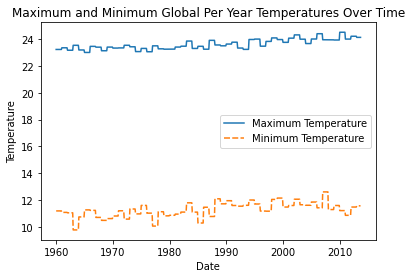

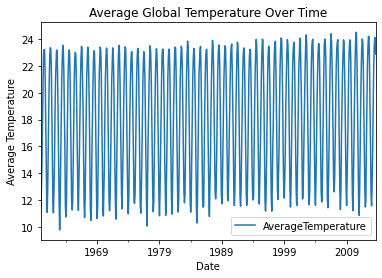

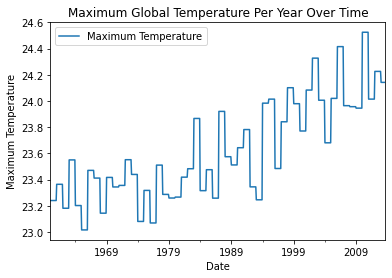

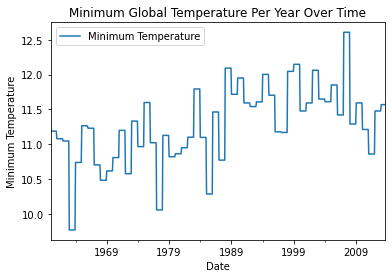

In [16]:
max_temps = temperatures_by_date_df.groupby(['Year']).max().reset_index()[['Year', 'AverageTemperature']]
max_temps = max_temps.rename(columns = {"AverageTemperature": "Maximum Temperature"})
min_temps = temperatures_by_date_df.groupby(['Year']).min().reset_index()[['Year', 'AverageTemperature']]
min_temps = min_temps.rename(columns = {"AverageTemperature": "Minimum Temperature"})
max_min_df = temperatures_by_date_df.merge(max_temps, how='inner', left_on=['Year'], right_on=['Year'])
max_min_df = max_min_df.merge(min_temps, how='inner', left_on=['Year'], right_on=['Year'])
max_min_df = max_min_df[["dt", "Maximum Temperature", "Minimum Temperature"]].set_index("dt")
plot = sns.lineplot(data=max_min_df)
plot.set(xlabel = "Date", ylabel = "Temperature", title="Maximum and Minimum Global Per Year Temperatures Over Time")
temperatures_by_date_df.plot(x = "dt", y = "AverageTemperature", xlabel="Date", ylabel="Average Temperature", title = "Average Global Temperature Over Time")
max_min_df = max_min_df.reset_index()
max_min_df.plot(x = "dt", y = "Maximum Temperature", xlabel="Date", ylabel="Maximum Temperature", title = "Maximum Global Temperature Per Year Over Time")
max_min_df.plot(x = "dt", y = "Minimum Temperature", xlabel="Date", ylabel="Minimum Temperature", title = "Minimum Global Temperature Per Year Over Time")

Clearly this plot of average temperatures over time fluctutates up and down each year due to seasonal changes. There seems to be minor increase in global average temperatures the last few years, but not as much as we would have expected based on narratives surrounding global warming.

In [17]:
# Prepare the dataset for plotting by longitude and latitude to see its distribution across the globe
average_temperatures_no_date_df = temperatures_df.groupby(["City"]).mean().reset_index()
average_temperatures_no_date_df

,City,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Year,Day,Month
0,A Coruña,13.652301,0.368661,42.59,-8.73,1986.335404,1.0,6.475155
1,Aachen,9.399410,0.242165,50.63,6.34,1986.335404,1.0,6.475155
2,Aalborg,8.257085,0.295441,57.05,10.33,1986.335404,1.0,6.475155
3,Aba,26.971637,0.398812,5.63,8.07,1986.335404,1.0,6.475155
4,Abadan,25.648095,0.521196,29.74,48.00,1986.335404,1.0,6.475155
...,...,...,...,...,...,...,...,...
3443,Århus,8.257085,0.295441,57.05,10.33,1986.335404,1.0,6.475155
3444,Çorlu,13.809488,0.291632,40.99,27.69,1986.335404,1.0,6.475155
3445,Çorum,10.494116,0.359792,40.99,34.08,1986.335404,1.0,6.475155
3446,Öskemen,2.146463,0.464626,50.63,82.39,1986.335404,1.0,6.475155


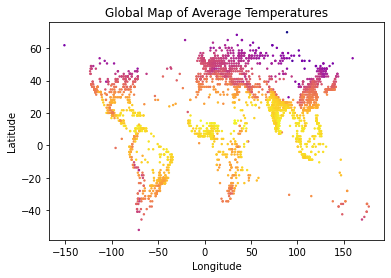

In [18]:
plt.scatter(average_temperatures_no_date_df.Longitude, average_temperatures_no_date_df.Latitude, s=2, c=average_temperatures_no_date_df.AverageTemperature, cmap='plasma')
plt.title('Global Map of Average Temperatures')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [19]:
temperatures_by_country_df = temperatures_df.groupby(['Country', "Year"]).mean().reset_index()
temperatures_by_country_df

,Country,Year,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Day,Month
0,Afghanistan,1960,13.939365,0.578937,34.15875,68.178750,1.0,6.5
1,Afghanistan,1961,13.817219,0.634417,34.15875,68.178750,1.0,6.5
2,Afghanistan,1962,13.615156,0.555167,34.15875,68.178750,1.0,6.5
3,Afghanistan,1963,14.695344,0.549208,34.15875,68.178750,1.0,6.5
4,Afghanistan,1964,13.062479,0.631115,34.15875,68.178750,1.0,6.5
...,...,...,...,...,...,...,...,...
8581,Zimbabwe,2009,20.106405,0.517286,-18.94000,30.255714,1.0,6.5
8582,Zimbabwe,2010,20.741714,0.467857,-18.94000,30.255714,1.0,6.5
8583,Zimbabwe,2011,20.366060,0.476560,-18.94000,30.255714,1.0,6.5
8584,Zimbabwe,2012,20.218274,0.640226,-18.94000,30.255714,1.0,6.5


In [20]:
import plotly.express as px

fig = px.scatter(temperatures_by_country_df, x = 'Longitude', y="Latitude", animation_frame="Year", animation_group="Country", color="AverageTemperature", hover_name="Country", size_max=20, width = 900, height = 490)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [21]:
len(pd.unique(temperatures_df['City']))

3448

We can see that our data is clustered in specific areas around the globe, which should be alright since our machine learning models will take location into account anyways when making predictions, and the data is still pretty widely spread across the entire world.

## Using Linear Regression to make predictions


Here we use linear regression on some of the features of our dataset to try and predict temperatures in the future based on time invariant data about latitude and longitude.


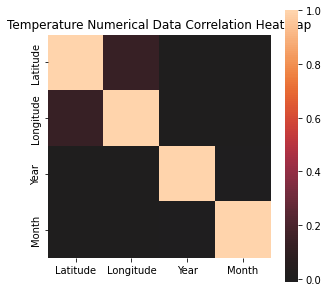

In [22]:
# Stores numerical features dataframe into variable called "features"
features = temperatures_df[['Latitude', 'Longitude', 'Year', 'Month']]

# Maps a correlation matrix for the numerical features
corr = features.corr()
plt.figure(figsize=(5, 5))
plot = sns.heatmap(corr, center=0, square=True)
plot.set(title = 'Temperature Numerical Data Correlation Heatmap')

# Store the regression target variable into "temperatures"
temperatures = temperatures_df['AverageTemperature']

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score

# Normal Linear Regression
clf = LinearRegression()
clf.fit(features, temperatures)

LinearRegression()

In [24]:
#want to check how many unique locations we have data for
temperatures_df['LatLong'] = temperatures_df["Latitude"].astype(str) + " " + temperatures_df["Longitude"].astype(str) 
unique_locations = pd.unique(temperatures_df['LatLong'])
print(len(unique_locations))

1366


In [25]:
future_df = pd.DataFrame(unique_locations, columns = ['LatLong'])
future_df = pd.merge(future_df, temperatures_df[['City', 'Country','Latitude', 'Longitude', 'LatLong']], on = 'LatLong', how = 'inner')
future_df.dtypes
temperatures_df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                float64
Longitude                               float64
Year                                      int64
Day                                       int64
Month                                     int64
LatLong                                  object
dtype: object

In [26]:
future_df = future_df.groupby(['LatLong']).min()
future_df = future_df.reset_index()
future_df

,LatLong,City,Country,Latitude,Longitude
0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41
1,-0.8 -49.02,Ananindeua,Brazil,-0.80,-49.02
2,-0.8 -77.95,Ambato,Ecuador,-0.80,-77.95
3,-0.8 -79.55,Quevedo,Ecuador,-0.80,-79.55
4,-0.8 -81.16,Manta,Ecuador,-0.80,-81.16
...,...,...,...,...,...
1361,8.84 77.03,Alappuzha,India,8.84,77.03
1362,8.84 8.92,Lafia,Nigeria,8.84,8.92
1363,8.84 80.27,Chavakachcheri,Sri Lanka,8.84,80.27
1364,8.84 81.89,Trincomalee,Sri Lanka,8.84,81.89


In [27]:
future_df['dates'] = [pd.date_range(start='1-1-2022', periods=12, freq='M') for i in range(len(future_df['City']))]
future_df = future_df.explode('dates')
future_df = future_df.reset_index()
future_df['Year'] = future_df['dates'].apply(lambda x : x.year)
future_df['Month'] = future_df['dates'].apply(lambda x : x.month)
future_df

,index,LatLong,City,Country,Latitude,Longitude,dates,Year,Month
0,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-01-31,2022,1
1,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-02-28,2022,2
2,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-03-31,2022,3
3,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-04-30,2022,4
4,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-05-31,2022,5
...,...,...,...,...,...,...,...,...,...
16387,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-08-31,2022,8
16388,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-09-30,2022,9
16389,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-10-31,2022,10
16390,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-11-30,2022,11


In [28]:
x_prediction = future_df[['Latitude', 'Longitude', 'Year', 'Month']]
y_pred = clf.predict(x_prediction)
future_df['predicted_temperature'] = y_pred
future_df

,index,LatLong,City,Country,Latitude,Longitude,dates,Year,Month,predicted_temperature
0,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-01-31,2022,1,21.149519
1,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-02-28,2022,2,21.441551
2,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-03-31,2022,3,21.733583
3,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-04-30,2022,4,22.025615
4,0,-0.8 -47.41,Castanhal,Brazil,-0.80,-47.41,2022-05-31,2022,5,22.317648
...,...,...,...,...,...,...,...,...,...,...
16387,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-08-31,2022,8,22.940359
16388,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-09-30,2022,9,23.232391
16389,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-10-31,2022,10,23.524424
16390,1365,8.84 99.73,Nakhon Si Thammarat,Thailand,8.84,99.73,2022-11-30,2022,11,23.816456


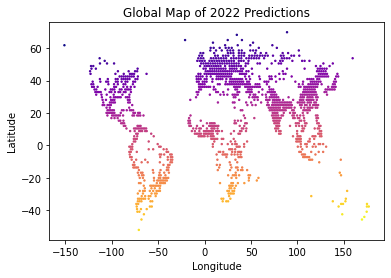

In [29]:
predictions_2022 = future_df.groupby('LatLong').mean()
predictions_2022
plt.scatter(predictions_2022.Longitude, predictions_2022.Latitude, s=2, c=predictions_2022.predicted_temperature, cmap='plasma')
plt.title('Global Map of 2022 Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

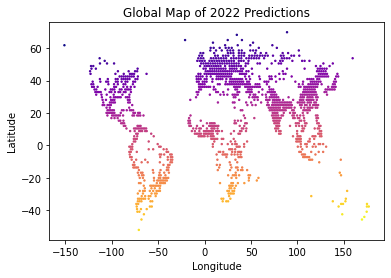

In [30]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(features, temperatures)
y_pred = clf.predict(x_prediction)
future_df['predicted_temperature'] = y_pred
predictions_2022 = future_df.groupby('LatLong').mean()
predictions_2022
plt.scatter(predictions_2022.Longitude, predictions_2022.Latitude, s=2, c=predictions_2022.predicted_temperature, cmap='plasma')
plt.title('Global Map of 2022 Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Both of our models created predictions that do not look very simliar to the initial map we plotted. Our predictions show that there is a positive correlation between being south and being hot. In the actual dataset, the correlation is only true for data above the equator.

What probably happened here is that we have many more data points above the equator and thus the trends the model follows are more similar to the patterns above the equator. Let's check to see if this is true.

In [31]:
north_df = temperatures_df.loc[(temperatures_df['Latitude'] >= 0)]
print(len(north_df))
south_df = temperatures_df.loc[(temperatures_df['Latitude'] <= 0)]
print(len(south_df))

1865464
395416


We can see that there is much more data in the northern hemisphere. Clearly there was an issue because the data was skewed towards trends in the nothern hemisphere. To try to mitigate this let's use distance from the equator instead of latitude.

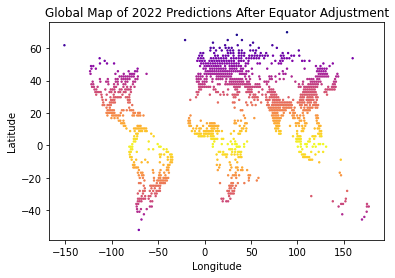

In [32]:
temperatures_df['Distance_From_Equator'] = temperatures_df['Latitude'].apply(lambda x: abs(x))
features = temperatures_df[['Distance_From_Equator', 'Longitude', 'Year', 'Month']]
temperatures = temperatures_df['AverageTemperature']
clf = LinearRegression()
clf.fit(features, temperatures)
future_df['Distance_From_Equator'] = future_df['Latitude'].apply(lambda x: abs(x))
x_prediction = future_df[['Distance_From_Equator', 'Longitude', 'Year', 'Month']]
y_pred = clf.predict(x_prediction)
future_df['predicted_temperature'] = y_pred
predictions_2022 = future_df.groupby('LatLong').mean()
plt.scatter(predictions_2022.Longitude, predictions_2022.Latitude, s=2, c=predictions_2022.predicted_temperature, cmap='plasma')
plt.title('Global Map of 2022 Predictions After Equator Adjustment')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

This map looks much more accurate than the other two! 

## Create and Clean Dataset on Environmental Technology Patents
https://data.oecd.org/envpolicy/patents-on-environment-technologies.htm

Encouraging collaboration on technology development is particularly pertinent when addressing global climate 
change or regional pollution. Importantly, international collaboration in research and technology can help 
local businesses take advantage of existing technologies (i.e. help build local absorptive capacity). This, in turn, helps increase the uptake of cleaner technologies globally.

In [33]:
patent_df = pd.read_csv('/content/Enviro-tech_patent.csv')
patent_df = patent_df[["LOCATION", "TIME", "Value"]]
patent_df = patent_df.rename(columns = {"LOCATION": "Country", "TIME": "Year", "Value": "Patents"}).sort_values(by='Year')
patent_df

,Country,Year,Patents
640,ISL,1960,40.12
118,BEL,1960,4.63
475,DEU,1960,4.02
1401,CHE,1960,4.35
780,JPN,1960,3.81
...,...,...,...
1702,ARG,2019,4.42
3197,PER,2019,8.22
1655,DZA,2019,29.95
1773,BGD,2019,6.03


In [34]:
# Dataset of countries and their 3 letter country codes from https://www.kaggle.com/datasets/juanumusic/countries-iso-codes
country_code_df = pd.read_csv('/content/country_codes.csv')
country_code_df = country_code_df.rename(columns = {"English short name lower case" : "Name", "Alpha-3 code": "Code"})
country_code_df = country_code_df.reset_index()
# Merge the two datasets together so that we can convert country codes into country names for joining
patent_df = patent_df.merge(country_code_df, how='inner', left_on='Country', right_on='Code')
patent_df = patent_df[['Name', 'Patents', 'Year']]
patent_df = patent_df.rename(columns = {"Name" : "Country"}).sort_values(by='Patents', ascending=False).reset_index(drop = True)
patent_df

,Country,Patents,Year
0,"Tanzania, United Republic of",100.00,1999
1,Lao People's Democratic Republic,100.00,2000
2,Sierra Leone,100.00,2018
3,Honduras,100.00,2014
4,Gabon,100.00,1980
...,...,...,...
3909,Finland,0.91,1967
3910,Cuba,0.86,2011
3911,Cyprus,0.84,2013
3912,New Zealand,0.71,1982


[Text(0, 0, 'Haiti'),
 Text(0, 0, 'Somalia'),
 Text(0, 0, 'Lesotho'),
 Text(0, 0, 'Yemen'),
 Text(0, 0, 'Equatorial Guinea'),
 Text(0, 0, 'Turkmenistan'),
 Text(0, 0, 'Chad'),
 Text(0, 0, 'Rwanda'),
 Text(0, 0, 'Palestinian Territory, Occupied'),
 Text(0, 0, 'Burundi'),
 Text(0, 0, 'Botswana'),
 Text(0, 0, 'Zambia'),
 Text(0, 0, 'Guinea'),
 Text(0, 0, 'Nicaragua'),
 Text(0, 0, 'Eritrea'),
 Text(0, 0, 'Congo'),
 Text(0, 0, 'Afghanistan'),
 Text(0, 0, 'Fiji'),
 Text(0, 0, 'Paraguay'),
 Text(0, 0, 'Tanzania, United Republic of'),
 Text(0, 0, 'Papua New Guinea'),
 Text(0, 0, 'Mauritania'),
 Text(0, 0, 'Central African Republic'),
 Text(0, 0, 'Madagascar'),
 Text(0, 0, 'Mozambique'),
 Text(0, 0, "Lao People's Democratic Republic"),
 Text(0, 0, 'Kyrgyzstan'),
 Text(0, 0, 'Liberia'),
 Text(0, 0, 'Benin'),
 Text(0, 0, 'Togo'),
 Text(0, 0, 'Syrian Arab Republic'),
 Text(0, 0, 'Cambodia'),
 Text(0, 0, 'Iraq'),
 Text(0, 0, 'Montenegro'),
 Text(0, 0, 'Burkina Faso'),
 Text(0, 0, 'Senegal'),
 Text(

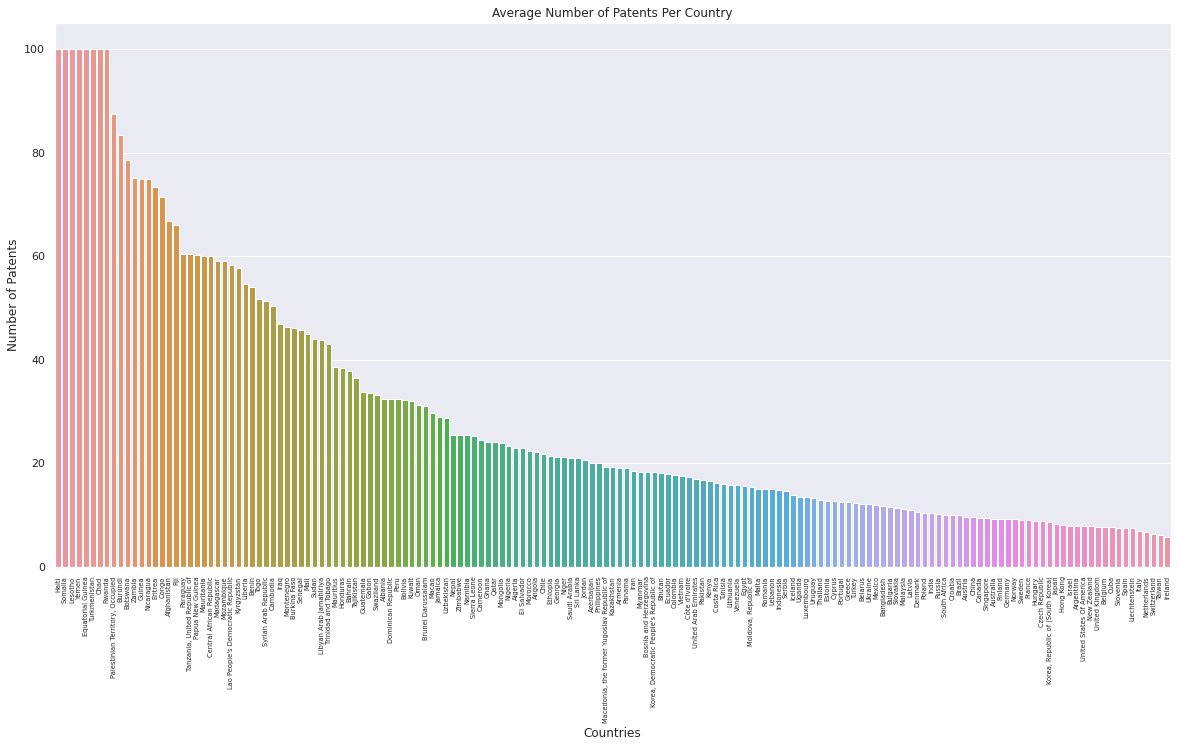

In [35]:
# Find the average number of patents per country and then plot the result
patent_by_country_df = patent_df.groupby(["Country"]).mean().reset_index()
patent_by_country_df = patent_by_country_df[["Country", "Patents"]]
patent_by_country_df = patent_by_country_df.sort_values(by='Patents', ascending=False)
patent_by_country_df

sns.set(rc={"figure.figsize":(20, 10)})
patentplot = sns.barplot(x = 'Country',y = 'Patents', data = patent_by_country_df)
patentplot.set(title = "Average Number of Patents Per Country")
patentplot.set_xlabel("Countries", fontsize = 12)
patentplot.set_ylabel("Number of Patents", fontsize = 12)
patentplot.set_xticklabels(patentplot.get_xticklabels(), rotation = 90, size = 6.6)

## Create and Clean Dataset on Environmental Policy
https://stats.oecd.org/Index.aspx?DataSetCode=EPS#

The OECD Environmental Policy Stringency Index (EPS) is a country-specific and internationally-comparable measure of the stringency of environmental policy. Stringency is defined as the degree to which environmental policies put an explicit or implicit price on polluting or environmentally harmful behaviour. The index ranges from 0 (not stringent) to 6 (highest degree of stringency). The index covers 28 OECD and 6 BRIICS countries for the period 1990-2012. The index is based on the degree of stringency of 14 environmental policy instruments, primarily related to climate and air pollution.

In [36]:
policy_df = pd.read_csv('/content/enviro_policy.csv')
policy_df

,COU,Country,VAR,Variable,YEA,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,GRC,Greece,ELV_DIESELSO,Sulphur content limit for diesel,1990,1990,IDX,Index,0,Units,NaN,NaN,1.00,NaN,NaN
1,GRC,Greece,ELV_DIESELSO,Sulphur content limit for diesel,1991,1991,IDX,Index,0,Units,NaN,NaN,1.00,NaN,NaN
2,GRC,Greece,ELV_DIESELSO,Sulphur content limit for diesel,1992,1992,IDX,Index,0,Units,NaN,NaN,1.00,NaN,NaN
3,GRC,Greece,ELV_DIESELSO,Sulphur content limit for diesel,1993,1993,IDX,Index,0,Units,NaN,NaN,2.00,NaN,NaN
4,GRC,Greece,ELV_DIESELSO,Sulphur content limit for diesel,1994,1994,IDX,Index,0,Units,NaN,NaN,2.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17645,IND,India,STD,Standards,2011,2011,IDX,Index,0,Units,NaN,NaN,1.25,NaN,NaN
17646,IND,India,STD,Standards,2012,2012,IDX,Index,0,Units,NaN,NaN,1.25,NaN,NaN
17647,IND,India,STD,Standards,2013,2013,IDX,Index,0,Units,NaN,NaN,1.25,NaN,NaN
17648,IND,India,STD,Standards,2014,2014,IDX,Index,0,Units,NaN,NaN,1.25,NaN,NaN


In [37]:
# We keep the columns that are important: Variable = 'Environmental Policy Stringency', Country, Value 
policy_df.info()
policy_df = policy_df[["Country", "Variable", "Value", "Year"]]
policy_df = policy_df.loc[policy_df['Variable'] == "Environmental Policy Stringency"]
policy_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17650 entries, 0 to 17649
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   COU                    17650 non-null  object 
 1   Country                17650 non-null  object 
 2   VAR                    17650 non-null  object 
 3   Variable               17650 non-null  object 
 4   YEA                    17650 non-null  int64  
 5   Year                   17650 non-null  int64  
 6   Unit Code              17650 non-null  object 
 7   Unit                   17650 non-null  object 
 8   PowerCode Code         17650 non-null  int64  
 9   PowerCode              17650 non-null  object 
 10  Reference Period Code  0 non-null      float64
 11  Reference Period       0 non-null      float64
 12  Value                  17650 non-null  float64
 13  Flag Codes             0 non-null      float64
 14  Flags                  0 non-null      float64
dtypes:

,Country,Variable,Value,Year
95,Belgium,Environmental Policy Stringency,0.666667,1990
96,Belgium,Environmental Policy Stringency,0.666667,1991
97,Belgium,Environmental Policy Stringency,0.708333,1992
98,Belgium,Environmental Policy Stringency,0.770833,1993
99,Belgium,Environmental Policy Stringency,0.770833,1994
...,...,...,...,...
17217,Indonesia,Environmental Policy Stringency,1.166667,2011
17218,Indonesia,Environmental Policy Stringency,1.166667,2012
17219,Indonesia,Environmental Policy Stringency,1.083333,2013
17220,Indonesia,Environmental Policy Stringency,1.083333,2014


In [38]:
policy_df = policy_df[["Country", "Value", "Year"]]
policy_df

,Country,Value,Year
95,Belgium,0.666667,1990
96,Belgium,0.666667,1991
97,Belgium,0.708333,1992
98,Belgium,0.770833,1993
99,Belgium,0.770833,1994
...,...,...,...
17217,Indonesia,1.166667,2011
17218,Indonesia,1.166667,2012
17219,Indonesia,1.083333,2013
17220,Indonesia,1.083333,2014


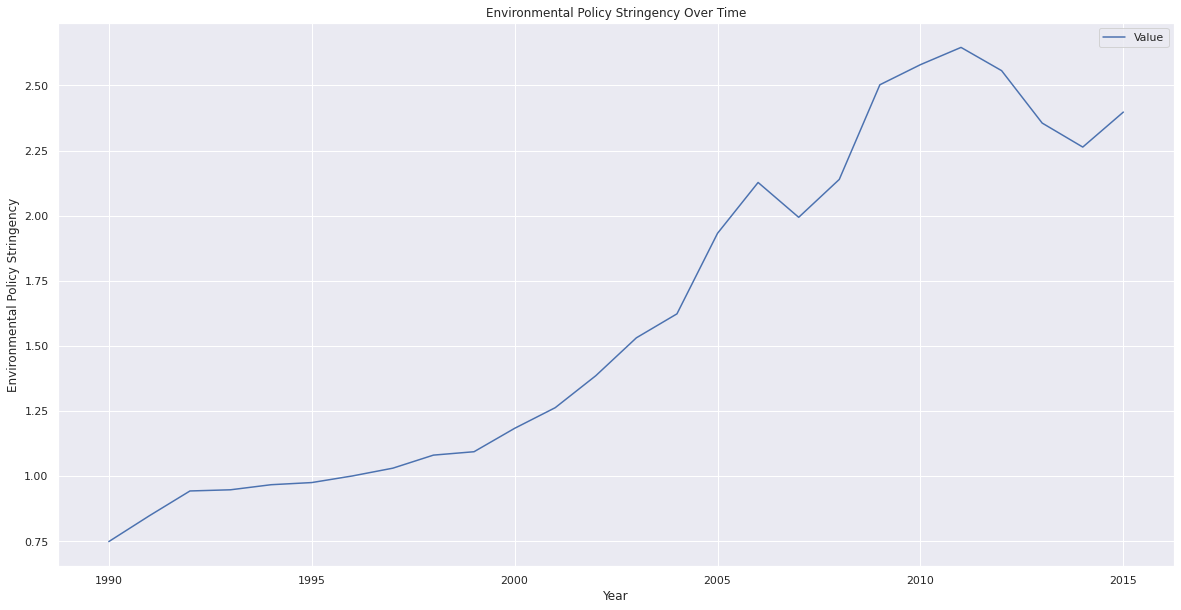

In [39]:
# Here once again Value stands for Environmental Policy Stringency, we take the average per year and plot the result
policy_by_date_df = policy_df.groupby(["Year"]).mean().reset_index()
policy_by_date_df.plot(x = "Year", y = "Value", ylabel="Environmental Policy Stringency", title = "Environmental Policy Stringency Over Time") 

Strictness of environmental policy increases over time globally with an interesting dip around 2014

[Text(0, 0, 'Denmark'),
 Text(0, 0, 'Germany'),
 Text(0, 0, 'Switzerland'),
 Text(0, 0, 'Austria'),
 Text(0, 0, 'Netherlands'),
 Text(0, 0, 'Slovenia'),
 Text(0, 0, 'Finland'),
 Text(0, 0, 'France'),
 Text(0, 0, 'Sweden'),
 Text(0, 0, 'Spain'),
 Text(0, 0, 'Italy'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Korea'),
 Text(0, 0, 'Japan'),
 Text(0, 0, 'Canada'),
 Text(0, 0, 'Norway'),
 Text(0, 0, 'Portugal'),
 Text(0, 0, 'United States'),
 Text(0, 0, 'Greece'),
 Text(0, 0, 'Australia'),
 Text(0, 0, 'Hungary'),
 Text(0, 0, 'Poland'),
 Text(0, 0, 'Czech Republic'),
 Text(0, 0, 'Belgium'),
 Text(0, 0, 'Slovak Republic'),
 Text(0, 0, 'Ireland'),
 Text(0, 0, 'Turkey'),
 Text(0, 0, "China (People's Republic of)"),
 Text(0, 0, 'India'),
 Text(0, 0, 'South Africa'),
 Text(0, 0, 'Indonesia'),
 Text(0, 0, 'Russia'),
 Text(0, 0, 'Brazil')]

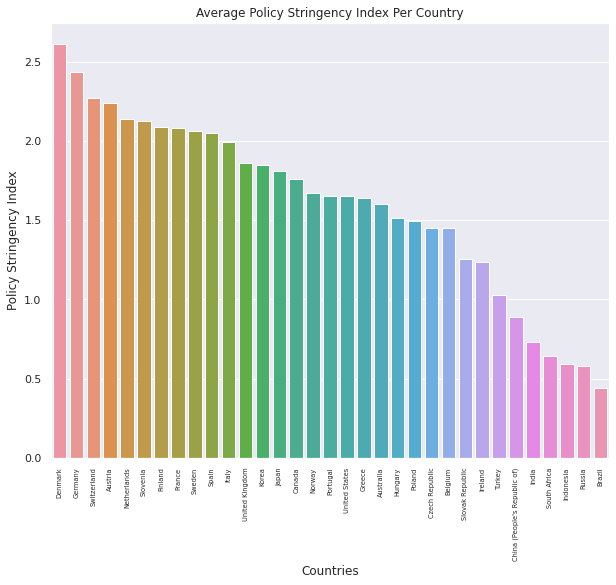

In [40]:
# Find average stringency by country, and then plot the result
policy_by_country_df = policy_df.groupby(["Country"]).mean().reset_index()
policy_by_country_df = policy_by_country_df[["Country", "Value"]]
policy_by_country_df = policy_by_country_df.sort_values(by='Value', ascending=False)
policy_by_country_df

sns.set(rc={"figure.figsize":(10, 8)})
policyplot = sns.barplot(x = 'Country',y = 'Value', data = policy_by_country_df)
policyplot.set(title = "Average Policy Stringency Index Per Country")
policyplot.set_xlabel("Countries", fontsize = 12)
policyplot.set_ylabel("Policy Stringency Index", fontsize = 12)
policyplot.set_xticklabels(policyplot.get_xticklabels(), rotation = 90, size = 6.6)

The most strict countries are all European: Denmark, Germany, Switzerland, Austria. The least strict are China, India, South Africa, Indonesia, Russia, and Brazil. 

## Merge the Datasets Together

Here we combine all of the datasets that we cleaned in the previous steps, merging on the country and the year. We also pull out numerical columns and the target average temperature column in preparation for the machine learning component to be performed below.

In [41]:
# Merge in the environmental policy stringency and patent number datasets, by country and year
merged_df = temperatures_df.merge(policy_df, how='inner', left_on=['Country', 'Year'], right_on=['Country', 'Year'])
merged_df = merged_df.rename(columns = {"Value": "Stringency", "AverageTemperatureUncertainty": "Uncertainty"})
merged_df = merged_df.merge(patent_df, how='inner', left_on=['Country', 'Year'], right_on=['Country', 'Year'])
merged_df

,dt,AverageTemperature,Uncertainty,City,Country,Latitude,Longitude,Year,Day,Month,LatLong,Distance_From_Equator,Stringency,Patents
0,1990-01-01,4.267,0.459,Århus,Denmark,57.05,10.33,1990,1,1,57.05 10.33,57.05,0.895833,8.92
1,1990-02-01,5.895,0.460,Århus,Denmark,57.05,10.33,1990,1,2,57.05 10.33,57.05,0.895833,8.92
2,1990-03-01,6.565,0.299,Århus,Denmark,57.05,10.33,1990,1,3,57.05 10.33,57.05,0.895833,8.92
3,1990-04-01,8.068,0.222,Århus,Denmark,57.05,10.33,1990,1,4,57.05 10.33,57.05,0.895833,8.92
4,1990-05-01,12.944,0.287,Århus,Denmark,57.05,10.33,1990,1,5,57.05 10.33,57.05,0.895833,8.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438264,2012-08-01,22.249,0.370,Ljubljana,Slovenia,45.81,15.00,2012,1,8,45.81 15.0,45.81,2.283333,9.20
438265,2012-09-01,16.596,0.267,Ljubljana,Slovenia,45.81,15.00,2012,1,9,45.81 15.0,45.81,2.283333,9.20
438266,2012-10-01,11.124,0.518,Ljubljana,Slovenia,45.81,15.00,2012,1,10,45.81 15.0,45.81,2.283333,9.20
438267,2012-11-01,8.077,0.436,Ljubljana,Slovenia,45.81,15.00,2012,1,11,45.81 15.0,45.81,2.283333,9.20


In [42]:
# Turns the categorical country column into a numerical one by converting every country to a number based on its index in the country codes dataframe
merged_df = merged_df.merge(country_code_df[['index', 'Name']], how='inner', left_on=['Country'], right_on=['Name'])
merged_df = merged_df.rename(columns = {"index": "Country ID"})
merged_df

,dt,AverageTemperature,Uncertainty,City,Country,Latitude,Longitude,Year,Day,Month,LatLong,Distance_From_Equator,Stringency,Patents,Country ID,Name
0,1990-01-01,4.267,0.459,Århus,Denmark,57.05,10.33,1990,1,1,57.05 10.33,57.05,0.895833,8.92,58,Denmark
1,1990-02-01,5.895,0.460,Århus,Denmark,57.05,10.33,1990,1,2,57.05 10.33,57.05,0.895833,8.92,58,Denmark
2,1990-03-01,6.565,0.299,Århus,Denmark,57.05,10.33,1990,1,3,57.05 10.33,57.05,0.895833,8.92,58,Denmark
3,1990-04-01,8.068,0.222,Århus,Denmark,57.05,10.33,1990,1,4,57.05 10.33,57.05,0.895833,8.92,58,Denmark
4,1990-05-01,12.944,0.287,Århus,Denmark,57.05,10.33,1990,1,5,57.05 10.33,57.05,0.895833,8.92,58,Denmark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438264,2012-08-01,22.249,0.370,Ljubljana,Slovenia,45.81,15.00,2012,1,8,45.81 15.0,45.81,2.283333,9.20,200,Slovenia
438265,2012-09-01,16.596,0.267,Ljubljana,Slovenia,45.81,15.00,2012,1,9,45.81 15.0,45.81,2.283333,9.20,200,Slovenia
438266,2012-10-01,11.124,0.518,Ljubljana,Slovenia,45.81,15.00,2012,1,10,45.81 15.0,45.81,2.283333,9.20,200,Slovenia
438267,2012-11-01,8.077,0.436,Ljubljana,Slovenia,45.81,15.00,2012,1,11,45.81 15.0,45.81,2.283333,9.20,200,Slovenia


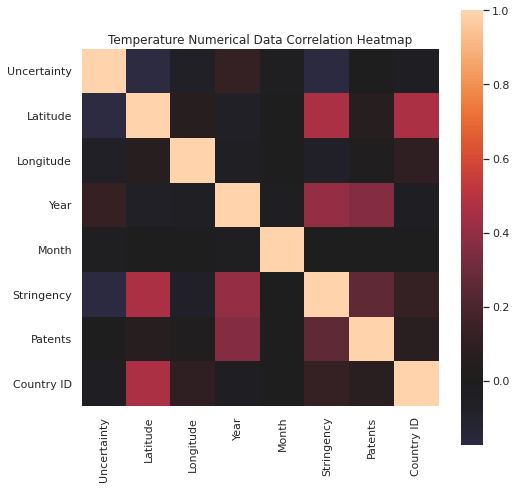

In [43]:
# Stores numerical features dataframe into variable called "features"
features = merged_df[['Uncertainty', 'Latitude', 'Longitude', 'Year', 'Month', 'Stringency', 'Patents', 'Country ID']]

# Maps a correlation matrix for the numerical features
corr = features.corr()
plt.figure(figsize=(8, 8))
plot = sns.heatmap(corr, center=0, square=True)
plot.set(title = 'Temperature Numerical Data Correlation Heatmap')

# Store the regression target variable into "temperatures"
temperatures = merged_df['AverageTemperature']

## Linear Regression in sklearn

Here we use linear regression on the merged dataset to train various linear regression models to try and find the one that performs the best on our dataset. 



In [44]:
from sklearn.model_selection import train_test_split

# Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(features, temperatures, test_size = 0.2, random_state = 42)

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score

# Normal Linear Regression
clf = LinearRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
score = r2_score(y_test, y_pred)
score

0.3858455456237728

Ordinary linear regression has minimized the mean squared error, but might overfit or contain multicollinearity, and so we try Lasso, Ridge, and Elastic Net Regression to try and address this.

In [46]:
from sklearn.linear_model import Lasso

# Lasso (L1) Regression
clf = Lasso(alpha=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
lasso_score = r2_score(y_test, y_pred)
lasso_score

0.3759705724278485

In [47]:
from sklearn.linear_model import Ridge

# Ridge (L2) Regression
clf = Ridge(alpha=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
ridge_score = r2_score(y_test, y_pred)
ridge_score

0.3858455316908166

In [48]:
from sklearn.linear_model import ElasticNet

# Elastic Net (L1 + L2) Regression
clf = ElasticNet(alpha=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
elastic_net_score = r2_score(y_test, y_pred)
elastic_net_score

0.3777773138667675

We can also try to eliminate collinearity between variables by performing PCA before we train our model.

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=8)
pca.fit_transform(StandardScaler().fit_transform(x_test))

array([[-1.10030734, -0.47362915,  0.44245535, ...,  0.66605673,
        -0.11195157,  0.18991395],
       [-1.27607253, -0.83534636, -0.60444769, ...,  0.10179228,
        -1.6162363 ,  0.17919485],
       [-2.29807899,  0.84371655, -1.58940907, ...,  0.53165296,
        -0.06586093,  0.15922305],
       ...,
       [ 0.72900951, -0.52128116, -1.91577975, ...,  0.58427518,
         0.87995948, -1.13687408],
       [ 0.09009402,  0.28348367, -0.36997868, ...,  0.37307238,
        -0.42671392, -0.80399342],
       [-0.88075368, -1.29146292, -0.39987587, ..., -0.50119733,
        -1.49190695, -0.24001849]])

In [50]:
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = pca.explained_variance_ratio_.cumsum()
cum_evr

array([0.24006449, 0.42847698, 0.55632221, 0.68178418, 0.80222905,
       0.89194901, 0.96290579, 1.        ])

[Text(0.5, 1.0, 'Cumulative Explained Variance Ratio Based on the Number of Components')]

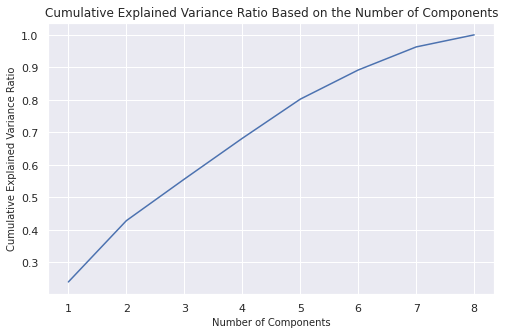

In [51]:
# We plot the cumulative explained variance ratio to decide on the number of components to keep, in this case the minimum
# number of components that explain at least 80% of total variance in the dataset
plt.figure(figsize=(8, 5))
# We do this to shift the number of components up by 1, since plotting without doing this starts a 0 given array indexing
evr_df = pd.DataFrame(cum_evr).reset_index()
evr_df['index'] = evr_df['index'].apply(lambda x : x + 1)
evr_df
plot = sns.lineplot(data=evr_df, x = 'index', y = 0)
plot.set_xlabel("Number of Components", fontsize=10)
plot.set_ylabel("Cumulative Explained Variance Ratio", fontsize=10)
plot.set(title="Cumulative Explained Variance Ratio Based on the Number of Components")

In [52]:
from sklearn.pipeline import Pipeline

# Pipelined Linear Regression with PCA
pca2 = PCA(n_components=5)
pca2.fit_transform(StandardScaler().fit_transform(x_test))
scl = StandardScaler()
clf = LinearRegression()
pipe = Pipeline(steps=[('Scale', scl), ('PCA', pca2), ('LinReg', clf)])
pipe.fit(x_train, y_train)
prediction = pipe.predict(x_test)
test_accuracy = r2_score(y_test, prediction)
test_accuracy

0.34802684040103926

In [53]:
# Linear Regression with PCA
pca3 = PCA(n_components=5)
clf2 = LinearRegression()
x_train_pca = pca3.fit_transform(StandardScaler().fit_transform(x_train))
clf2.fit(x_train_pca, y_train)
x_test_pca = pca3.transform(StandardScaler().fit_transform(x_test))
prediction2 = clf2.predict(x_test_pca)
test_accuracy2 = r2_score(y_test, prediction2)
test_accuracy2

0.3481509573287097

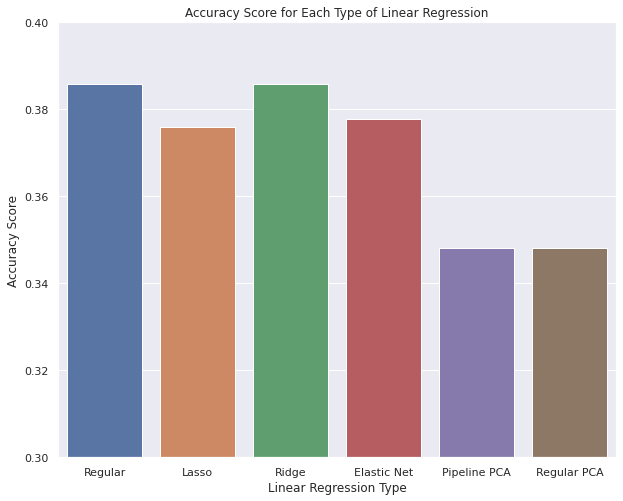

In [54]:
score_bar_data = {"Regular": score, "Lasso": lasso_score, "Ridge": ridge_score, "Elastic Net": elastic_net_score, 
                  "Pipeline PCA": test_accuracy, "Regular PCA": test_accuracy2}
sns.set(rc={"figure.figsize":(10, 8)})
bar_series_data = pd.Series(score_bar_data, name="Accuracy Score").to_frame().reset_index()
bar_series_data
plot = sns.barplot(x="index", y="Accuracy Score", data= bar_series_data)
plot.set(xlabel = 'Linear Regression Type')
plot.set(ylabel = 'Accuracy Score')
plot.set(title = 'Accuracy Score for Each Type of Linear Regression')
plot.set(ylim=(0.3, 0.4))
plot.tick_params(axis='x', which='major')

Overall we can see that regular linear regression and ridge regression performed the best out of all the different methods used, and had very similar results. This is because it is likely that our list of features contains multicollinearity, given the relationships between country code and longitude and latitude, as well as between these specific countries and their policies and patent numbers. Regular linear regression tends to have the possibility of overfitting here, and Ridge regression can do better than Lasso in the presence of collinearity, explaining these high performance values.

We note that perorming PCA did not significantly change our testing accuracy, and in fact caused it to go down, which is likely because we do not have that many features, and also because our features are generally not correlated.

We do not perform predictions using this linear regression as we did above, because the data here like environmental stringency is not time invariant like the location data from above, and so we cannot fill in this data for the future to make predictions with it using linear regression. However, these models can be used to fill in gaps in temperature data from past dates where we do have this other numerical data. 


## Deep Learning Using Neural Networks

Here we train a feedforward neural network model to try and gauge its performance on the dataset. As is mentioned in the challenges section, originally without normalizing the data this neural network's loss would fluctuate wildly between different values, sometimes ending up at higher values than it started at, likely because of the wide range of numerical values in the data. However, after normalizing, a clear downward trend can be noted.

In [55]:
# This line is used to significantly speed up the training of the deep neural net, can be commented out or adjusted but generally
# if we use the whole dataset the training takes an incredibly long time
new_merged_df = merged_df[merged_df.dt >= '2011-01-01'].reset_index(drop = True)
new_merged_df.info()
# Stores numerical features dataframe into variable
deep_features = new_merged_df[['Uncertainty', 'Latitude', 'Longitude', 'Year', 'Month', 'Stringency', 'Patents', 'Country ID']]
# Store the regression target variable
deep_temperatures = new_merged_df['AverageTemperature']

x_train, x_test, y_train, y_test = train_test_split(deep_features, deep_temperatures, test_size = 0.2)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

x_train = NormalizeData(np.array(x_train.to_numpy(), dtype=np.float32))
y_train = NormalizeData(np.array(y_train.to_numpy(dtype=np.float32).reshape(-1,1), dtype=np.float32))
x_test = NormalizeData(np.array(x_test.to_numpy(), dtype=np.float32))
y_test = NormalizeData(np.array(y_test.to_numpy().reshape(-1,1), dtype=np.float32))
train_dataset = mx.gluon.data.dataset.ArrayDataset(x_train, y_train)
test_dataset = mx.gluon.data.dataset.ArrayDataset(x_test, y_test)
train_data = mx.gluon.data.DataLoader(train_dataset, 10, shuffle=True)
test_data = mx.gluon.data.DataLoader(test_dataset, 1, shuffle=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50825 entries, 0 to 50824
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dt                     50825 non-null  datetime64[ns]
 1   AverageTemperature     50825 non-null  float64       
 2   Uncertainty            50825 non-null  float64       
 3   City                   50825 non-null  object        
 4   Country                50825 non-null  object        
 5   Latitude               50825 non-null  float64       
 6   Longitude              50825 non-null  float64       
 7   Year                   50825 non-null  int64         
 8   Day                    50825 non-null  int64         
 9   Month                  50825 non-null  int64         
 10  LatLong                50825 non-null  object        
 11  Distance_From_Equator  50825 non-null  float64       
 12  Stringency             50825 non-null  float64       
 13  P

In [56]:
from mxnet.gluon import nn
from mxnet import gluon, autograd, ndarray
from mxnet import init

def construct_net():
    net = nn.Sequential()
    with net.name_scope():
      net.add(nn.Dense(10))
      net.add(nn.Dense(1))
    return net

net = construct_net()

ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

net.initialize(init.Normal(sigma=0.01), ctx=ctx)

Here we use L1 Loss, also called Mean Absolute Error, which computes the sum of absolute distance between target values and the output of the neural network.

Further described here: https://mxnet.apache.org/versions/1.7/api/python/docs/tutorials/packages/gluon/loss/loss.html


Epoch 0 Loss: 0.007860365323722363

Epoch 0 Accuracy: 0.9998901055837867

Epoch 1 Loss: 0.007334065157920122

Epoch 1 Accuracy: 0.9999406305827615

Epoch 2 Loss: 0.007027862593531609

Epoch 2 Accuracy: 0.9999441460059013

Epoch 3 Loss: 0.006910738535225391

Epoch 3 Accuracy: 0.9997124142822287

Epoch 4 Loss: 0.006870529148727655

Epoch 4 Accuracy: 0.9994735277926627

Epoch 5 Loss: 0.006873586215078831

Epoch 5 Accuracy: 0.9994299122492076

Epoch 6 Loss: 0.006959331221878529

Epoch 6 Accuracy: 0.9996100688266824

Epoch 7 Loss: 0.007069113198667765

Epoch 7 Accuracy: 0.9995724407195647

Epoch 8 Loss: 0.006851655431091785

Epoch 8 Accuracy: 0.9995204776515154

Epoch 9 Loss: 0.006855708546936512

Epoch 9 Accuracy: 0.9996381670494603


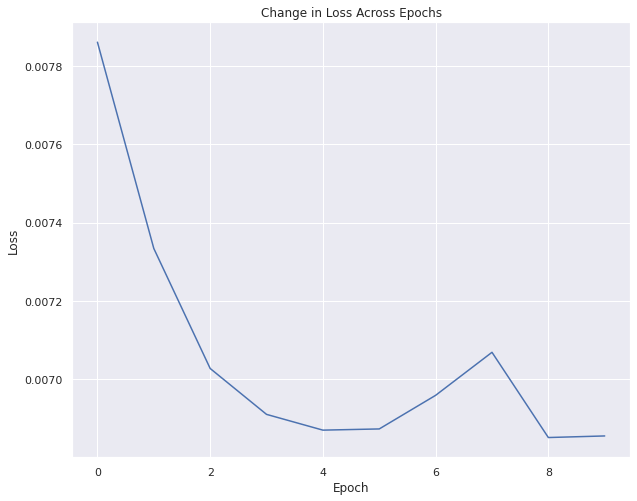

In [57]:
from mxnet.gluon import loss as gloss

metric = mx.metric.Accuracy()

loss = gloss.L2Loss()

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})
loss_plot_dict = {}
for epoch in range(10):
    total_accuracy = 0
    for x, y in train_data:
      x = x.as_in_context(ctx)
      y = y.as_in_context(ctx)
      with autograd.record():
          l = loss(net(x), y)
      l.backward()
      trainer.step(10)
      metric.update(preds = net(x).as_nd_ndarray(), labels = y)
      total_accuracy += metric.get()[1].item()
    x_train = x_train.as_in_context(ctx)
    y_train = y_train.as_in_context(ctx)
    metric.reset()
    epoch_loss = loss(net(x_train), y_train).mean().item()
    epoch_accuracy = total_accuracy / len(train_data)
    loss_plot_dict[epoch] = epoch_loss
    print(f'\nEpoch {epoch} Loss: {epoch_loss}')
    print(f'\nEpoch {epoch} Accuracy: {epoch_accuracy}')

loss_plot_df = pd.DataFrame.from_dict(loss_plot_dict, orient='index')
plt.plot(loss_plot_df)
plt.title("Change in Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [58]:
total_accuracy = 0
for x, y in test_data:
  x = x.as_in_context(ctx)
  y = y.as_in_context(ctx)
  with autograd.record():
      l = loss(net(x), y)
  l.backward()
  metric.update(preds = net(x).as_nd_ndarray(), labels = y)
  total_accuracy += metric.get()[1].item()
x_train = x_train.as_in_context(ctx)
y_train = y_train.as_in_context(ctx)
metric.reset()
epoch_loss = loss(net(x_train), y_train).mean().item()
epoch_accuracy = total_accuracy / len(test_data)
print(f'\nTest Loss: {epoch_loss}')
print(f'\nTest Accuracy: {epoch_accuracy}')


Test Loss: 0.006855708546936512

Test Accuracy: 0.9997376545458085



Note that the loss and accuracy outputs fluctuate somewhat, likely because of the small subset of the dataset we are using to reduce the training set, although there is still clearly a downward trend in loss (the value is small because before we run the neural network we normalize all data to be between 0 and 1). If we were to include all of the data that we have and train over more epochs, it is likely that the model would perform better.

## New Jersey Data
In our previous dataset we did not have many columns which probably made the models less accurate. In this section we will try the same models on a dataset with more features that are weather related to see if that improves accuracy.

The data below was pulled from NOAA's global summary of the month dataset. https://www.ncdc.noaa.gov/cdo-web/datasets

In order to get the data used below I queried the data set for weather data from New Jersey one year at a time because there was a limit on how much data you could order at once. Then I combined 10 years worth of data into one dataset. 

In [59]:
NJ_df = pd.read_csv('/content/NJ_weather.csv')
NJ_df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,CLDD,HTDD,PRCP,TAVG,TMAX,TMIN
0,US1NJOC0058,"STAFFORD TWP 2.8 NNW, NJ US",39.741211,-74.290681,28.7,2021-01,NaN,NaN,NaN,1.96,NaN,NaN,NaN
1,US1NJOC0058,"STAFFORD TWP 2.8 NNW, NJ US",39.741211,-74.290681,28.7,2021-02,NaN,NaN,NaN,5.30,NaN,NaN,NaN
2,US1NJOC0058,"STAFFORD TWP 2.8 NNW, NJ US",39.741211,-74.290681,28.7,2021-03,NaN,NaN,NaN,3.59,NaN,NaN,NaN
3,US1NJOC0058,"STAFFORD TWP 2.8 NNW, NJ US",39.741211,-74.290681,28.7,2021-04,NaN,NaN,NaN,3.43,NaN,NaN,NaN
4,US1NJOC0058,"STAFFORD TWP 2.8 NNW, NJ US",39.741211,-74.290681,28.7,2021-05,NaN,NaN,NaN,3.80,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29196,USC00289363,"WERTSVILLE 4 NE, NJ US",40.452010,-74.779110,86.3,2012-08,NaN,249.0,0.0,6.94,73.3,83.5,63.1
29197,USC00289363,"WERTSVILLE 4 NE, NJ US",40.452010,-74.779110,86.3,2012-09,NaN,94.0,75.0,2.80,65.6,76.4,54.9
29198,USC00289363,"WERTSVILLE 4 NE, NJ US",40.452010,-74.779110,86.3,2012-10,NaN,3.0,313.0,4.72,55.0,63.6,46.4
29199,USC00289363,"WERTSVILLE 4 NE, NJ US",40.452010,-74.779110,86.3,2012-11,NaN,0.0,696.0,1.38,40.1,48.3,32.0


Looking at the dataframe there seems to be a lot of data missing. If we were to get rid of all rows with at least one NaN we would not have enough data points. Let's use a threshold instead. However since we are predicting on average temperature we need to make sure we get rid of all NaN's in the TAVG column.

In [60]:
NJ_df = NJ_df.dropna(thresh=8).dropna(subset=['TAVG'])
NJ_df = NJ_df.drop(columns=['AWND'])
NJ_df['Year'] = NJ_df['DATE'].apply(lambda x : int(x[:4]))
NJ_df['Month'] = NJ_df['DATE'].apply(lambda x : int(x[5:]))
NJ_df = NJ_df.fillna(0)
NJ_df = NJ_df.rename(columns = {'CLDD': 'COOLING_DEGREE_DAYS', 'HTDD': 'HEATING_DEGREE_DAYS', 'PRCP': 'PRECIPITATION'})
NJ_df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,COOLING_DEGREE_DAYS,HEATING_DEGREE_DAYS,PRECIPITATION,TAVG,TMAX,TMIN,Year,Month
101,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2021-01,0.0,926.0,1.83,35.1,44.9,25.4,2021,1
102,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2021-02,0.0,851.0,6.39,34.6,42.5,26.8,2021,2
103,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2021-03,0.0,615.0,5.63,45.2,57.3,33.0,2021,3
104,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2021-04,18.0,358.0,3.03,53.7,66.5,40.8,2021,4
105,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2021-05,80.0,172.0,3.06,62.0,74.7,49.4,2021,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29196,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2012-08,249.0,0.0,6.94,73.3,83.5,63.1,2012,8
29197,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2012-09,94.0,75.0,2.80,65.6,76.4,54.9,2012,9
29198,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2012-10,3.0,313.0,4.72,55.0,63.6,46.4,2012,10
29199,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2012-11,0.0,696.0,1.38,40.1,48.3,32.0,2012,11


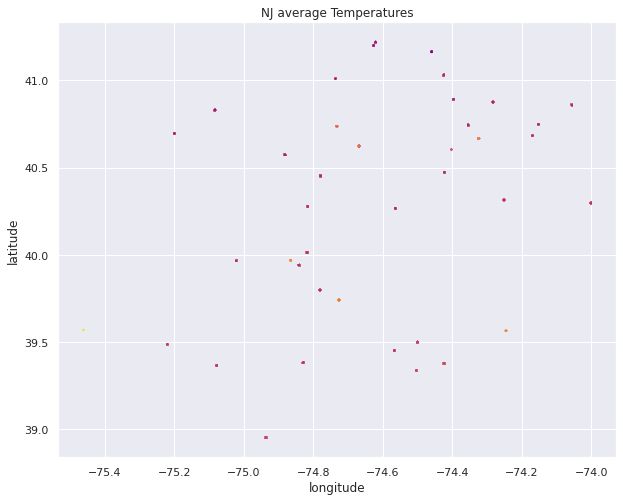

In [61]:
plt.scatter(NJ_df.LONGITUDE, NJ_df.LATITUDE, s=2, c=NJ_df.TAVG, cmap='plasma')
plt.title('NJ average Temperatures')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

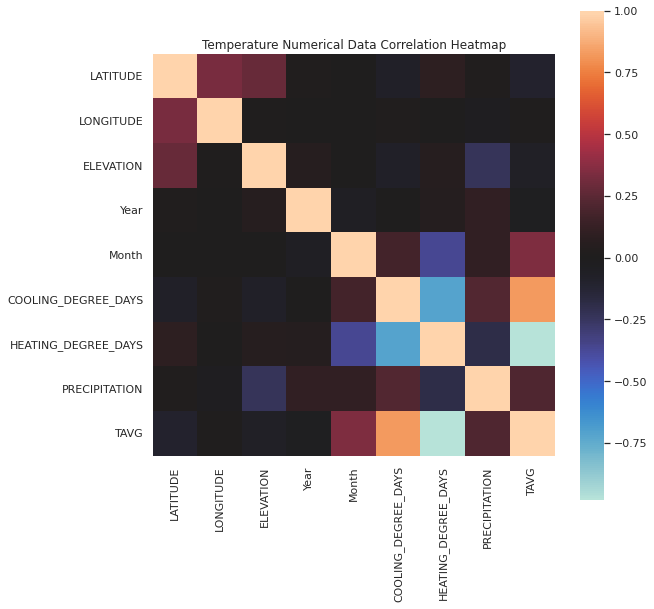

In [62]:
# Stores numerical features dataframe into variable called "features"
features = NJ_df[['LATITUDE', 'LONGITUDE', 'ELEVATION', 'Year', 'Month', 'COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS', 'PRECIPITATION']]

# Maps a correlation matrix for the numerical features and the target variable.
corr = NJ_df[['LATITUDE', 'LONGITUDE', 'ELEVATION', 'Year', 'Month', 'COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS', 'PRECIPITATION', 'TAVG']].corr()
plt.figure(figsize=(9, 9))
plot = sns.heatmap(corr, center=0, square=True)
plot.set(title = 'Temperature Numerical Data Correlation Heatmap')

# Store the regression target variable into "temperatures"
temperatures = NJ_df['TAVG']

Now we will perform Linear Regression

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(features, temperatures, test_size = 0.2, random_state = 42)

In [64]:
# Normal Linear Regression
clf = LinearRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
score = r2_score(y_test, y_pred)
score

0.9962861796781272

In [65]:
# Lasso (L1) Regression
clf = Lasso(alpha=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
lasso_score = r2_score(y_test, y_pred)
lasso_score

0.996289049087855

In [66]:
# Ridge (L2) Regression
clf = Ridge(alpha=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
ridge_score = r2_score(y_test, y_pred)
ridge_score

0.9962862359120948

In [67]:
# Elastic Net (L1 + L2) Regression
clf = ElasticNet(alpha=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
elastic_net_score = r2_score(y_test, y_pred)
elastic_net_score

0.9963103277424621

The R^2 scores of all of the linear regression models were all very high. Next we will use a feed forward NN.

In [68]:
deep_features = NJ_df[['LATITUDE', 'LONGITUDE', 'ELEVATION', 'Year', 'Month', 'COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS', 'PRECIPITATION']]
# Store the regression target variable
deep_temperatures = NJ_df['TAVG']

x_train, x_test, y_train, y_test = train_test_split(deep_features, deep_temperatures, test_size = 0.2)
x_train = np.array(x_train.to_numpy(), dtype=np.float32)
y_train = np.array(y_train.to_numpy(dtype=np.float32).reshape(-1,1), dtype=np.float32)
x_test = np.array(x_test.to_numpy(), dtype=np.float32)
y_test = np.array(y_test.to_numpy().reshape(-1,1), dtype=np.float32)
train_dataset = mx.gluon.data.dataset.ArrayDataset(x_train, y_train)
test_dataset = mx.gluon.data.dataset.ArrayDataset(x_test, y_test)
train_data = mx.gluon.data.DataLoader(train_dataset, 10, shuffle=True)
test_data = mx.gluon.data.DataLoader(test_dataset, 1, shuffle=False)

In [69]:
from mxnet.gluon import nn
from mxnet import gluon, autograd, ndarray
from mxnet import init

def construct_net():
    net = nn.Sequential()
    with net.name_scope():
      net.add(nn.Dense(5))
      net.add(nn.Dense(1))
    return net

net = construct_net()

ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

net.initialize(init.Normal(sigma=0.01), ctx=ctx)

accuracy:[0.09997127262280954, 0.30824475725366274, 0.4754380925021546, 0.5214018960068946, 0.5015800057454755, 0.511921861534042, 0.4610744039069233, 0.48147084171215165, 0.4803217466245332, 0.4438379775926458, 0.4630853203102557, 0.43636885952312554, 0.4762999138178684, 0.44096523987359953, 0.4268888250502729, 0.45360528583740306, 0.43091065785693766, 0.4277506463659868, 0.44125251364550416, 0.4418270611893134, 0.4320597529445562, 0.42229244469979893, 0.4501580005745475, 0.46164895145073254, 0.4395288710140764, 0.4576271186440678, 0.43091065785693766, 0.45935076127549557, 0.4538925596093077, 0.41597242171789717, 0.4245906348750359, 0.42229244469979893, 0.428325193909796, 0.4492961792588337, 0.42976156276931915, 0.44326343004883656, 0.42861246768170064, 0.4587762137316863, 0.4754380925021546, 0.46078713013501865, 0.43636885952312554, 0.44096523987359953, 0.42401608733122664, 0.40361964952599827, 0.42717609882217755, 0.4599253088193048, 0.43292157426027006, 0.44785981039931055, 0.43205

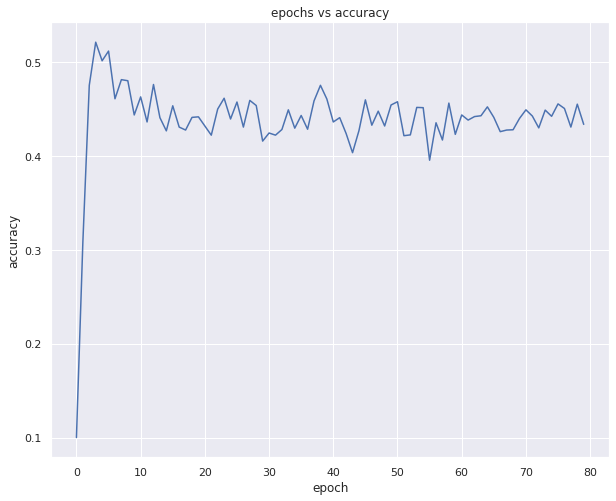

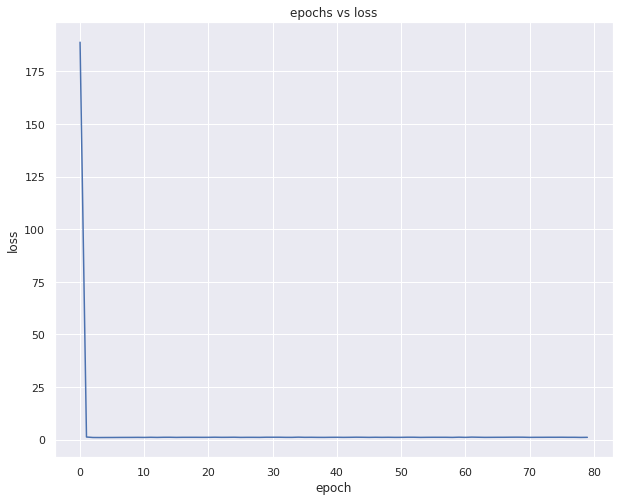

0.4337833955759839 1.0378707647323608


In [70]:
from sklearn import metrics
from mxnet.gluon import loss as gloss

def train_network(net, train_loader, criterion, trainer, metric, epochs):
    accuracies = []
    losses = []
    epoch_list = [i for i in range(epochs)]
    for i in range(epochs):
      metric.reset()
      total_accuracy = 0
      total_loss = 0
      samples = 0
      for data, labels in train_loader:
        data = data.reshape((data.shape[0], -1))
        data = data.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        with autograd.record():
          output = net(data)
          loss = criterion(output,labels)
        loss.backward()
        trainer.step(data.shape[0])
        metric.update(labels=labels.as_nd_ndarray(), preds = output.as_nd_ndarray())
        total_loss += loss.sum()
        samples += data.shape[0]
        total_accuracy = metric.get()[1]
      losses.append(total_loss/samples)
      accuracies.append(metric.get()[1])
    print('accuracy:' + str(accuracies) + ' loss:' + str(losses))
    plt.plot(epoch_list, accuracies, label = "accuracy")
    plt.title("epochs vs accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(epoch_list, losses, label = "loss")
    plt.title("epochs vs loss")
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.show()
    final_training_accuracy = float(metric.get()[1])
    final_training_loss = float(total_loss/samples)
    return final_training_accuracy, final_training_loss
  
trainer = gluon.Trainer(net.collect_params(), 'adam', optimizer_params={'learning_rate': 0.001})
epochs = 80
metric = mx.metric.Accuracy()
from mxnet.gluon import loss as gloss
loss = gloss.L2Loss()
lr_training_accuracy, lr_training_loss = train_network(net, train_data, loss, trainer, metric, epochs)
print(lr_training_accuracy, lr_training_loss)

loss: 0.6973832 accuracy: 0.5683122847301951


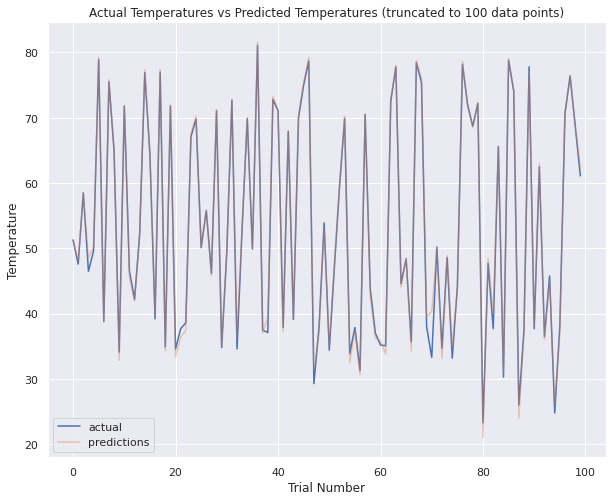

In [71]:
def test_model(net, criterion, test_loader, metric):
    total_accuracy = 0
    total_loss = 0
    samples = 0
    predictions = []
    actual = []
    metric.reset()
    for data, labels in test_loader:
      data = data.reshape((data.shape[0], -1))
      data = data.as_in_context(ctx)
      labels = labels.as_in_context(ctx)
      with autograd.record():
        output = net(data)
        loss = criterion(output,labels)
      predictions.append(output.item())
      actual.append(labels.item())
      metric.update(labels=labels.as_nd_ndarray(), preds = output.as_nd_ndarray())
      total_loss += loss.sum()
      samples += data.shape[0]
      total_accuracy = metric.get()[1]
    print('loss: ' + str(total_loss/samples) + ' accuracy: ' + str(total_accuracy))
    tests = [i for i in range(len(actual))]
    plt.plot(tests[:100], actual[:100], label = "actual")
    plt.plot(tests[:100], predictions[:100], label = "predictions", alpha = 0.4)
    plt.legend()
    plt.title("Actual Temperatures vs Predicted Temperatures (truncated to 100 data points)")
    plt.xlabel('Trial Number')
    plt.ylabel('Temperature')
    plt.show()
    testing_accuracy = float(total_accuracy)
    testing_loss = float(total_loss/samples)
    return  testing_loss, testing_accuracy
metric = mx.metric.Accuracy()  
lr_testing_loss, lr_testing_accuracy = test_model(net, loss, test_data, metric)

In [72]:
NJ_2011_df = pd.read_csv('/content/NJ_weather_2011.csv')
NJ_2011_df = NJ_2011_df.dropna(thresh=8).dropna(subset=['TAVG'])
NJ_2011_df = NJ_2011_df.drop(columns=['AWND'])
NJ_2011_df['Year'] = NJ_2011_df['DATE'].apply(lambda x : int(x[:4]))
NJ_2011_df['Month'] = NJ_2011_df['DATE'].apply(lambda x : int(x[5:]))
NJ_2011_df = NJ_2011_df.fillna(0)
NJ_2011_df = NJ_2011_df.rename(columns = {'CLDD': 'COOLING_DEGREE_DAYS', 'HTDD': 'HEATING_DEGREE_DAYS', 'PRCP': 'PRECIPITATION'})
NJ_2011_df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,COOLING_DEGREE_DAYS,HEATING_DEGREE_DAYS,PRECIPITATION,TAVG,TMAX,TMIN,Year,Month
5,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2011-01,0.0,1121.0,3.77,28.8,38.7,19.0,2011,1
6,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2011-02,0.0,786.0,2.39,36.9,49.4,24.4,2011,2
7,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2011-03,0.0,689.0,5.29,42.8,54.7,30.8,2011,3
8,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2011-04,44.0,305.0,4.85,56.3,66.8,45.8,2011,4
9,USC00282805,"ESTELL MANOR, NJ US",39.38293,-74.82932,25.9,2011-05,99.0,106.0,2.16,64.8,76.1,53.4,2011,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2011-08,223.0,0.0,17.16,73.0,83.2,62.8,2011,8
2153,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2011-09,127.0,50.0,8.58,67.6,75.8,59.4,2011,9
2154,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2011-10,6.0,317.0,4.80,54.6,64.2,45.1,2011,10
2155,USC00289363,"WERTSVILLE 4 NE, NJ US",40.45201,-74.77911,86.3,2011-11,0.0,501.0,3.76,47.8,58.1,37.5,2011,11


loss: 3.2707584 accuracy: 0.5087281795511222


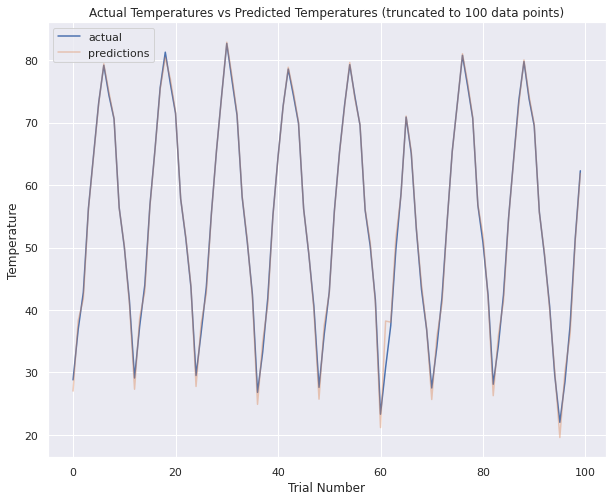

In [73]:
deep_features_2011 = NJ_2011_df[['LATITUDE', 'LONGITUDE', 'ELEVATION', 'Year', 'Month', 'COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS', 'PRECIPITATION']]
# Store the regression target variable
deep_temperatures_2011 = NJ_2011_df['TAVG']
deep_features_2011 = np.array(deep_features_2011.to_numpy(), dtype=np.float32)
deep_temperatures_2011 = np.array(deep_temperatures_2011.to_numpy().reshape(-1,1), dtype=np.float32)
test_2011_dataset = mx.gluon.data.dataset.ArrayDataset(deep_features_2011, deep_temperatures_2011)
test_2011_data = mx.gluon.data.DataLoader(test_2011_dataset, 1, shuffle=False)
metric = mx.metric.Accuracy()  
lr_testing_loss, lr_testing_accuracy = test_model(net, loss, test_2011_data, metric)

For the above graph, the gray line is where the actual value and the predicted value overlap.

While the accuracy is not that high in the graph, the loss is relatively low. For the purposes of predicting temperature a 3.2 loss is pretty low. Thus, the model is pretty successful. 

While this model can't be used to make predictions on future temperatures because we don't have access to climate data for the future, it can be used to fill in missing historical data. For example, I had to eliminate a lot of NaN's in the NJ dataset but with our model above we could try to estimate what those NaN's would have been. 

## Description of Challenges/ Obstacles Faced



1.   Setting up the neural network was quite difficult, as it despite trying out all manners of different losses, layers, initializations, trainer parameters, and batch sizes, for the longest time the model would just fluctuate back and forth between large loss values, sometimes ending on a higher loss than it started at. We eventually fixed this problem by normalizing all the data to be between the range 0 and 1.

2.   Finding extra data to join was also an obstacle initially, since our temperature dataset doesn't in and of itself contain many features that could be used to train linear regression/neural network models. Finding data that had information on date and location, as well as a useful numerical component useful for predicting temperature, was definitely a challenge although we eventually merged in outside data to create more features for machine learning.

3. Predicting future temperatures was very difficult because most of the features used to predict temperatures in our models, like climate and policy scores, are data that we do not have for the future. For example, we can't use the rainfall from 2023 to predict temperatures in 2023 because we don't know what the rainfall in 2023 will be. As a result, our model used to predict future temperatures was only trained off of data that does not change overtime, which in the case of our dataset was just location. 



## Potential Next Steps/ Future Direction


1.   We use linear regression to predict future values, but we don't do so with the neural network. Given more time, we could also use the neural network that we trained to predict future temperature values.

2.  Despite merging in various datasets into our original temperature dataset, there is still definitely room to find other features that might predict future temperature changes, and add them to the dataset to better train the machine learning models. Things like spending on environmental research, reliance on fossil fuels, and general weather forecasts are all things that could be researched, cleaned, and merged into the dataset to add more features to the machine learning model.

3. ARIMA can be used to predict/forecast data values that are seasonal, which our dataset of temperatures clearly is. Given more time ARIMA could definitely be used to try and predict the same temperatures, and its performance could be compared to that of our linear regression to see which performs better. 

